Running simulation 20 times...


Running Simulations: 100%|██████████| 20/20 [00:00<00:00, 122.22it/s]


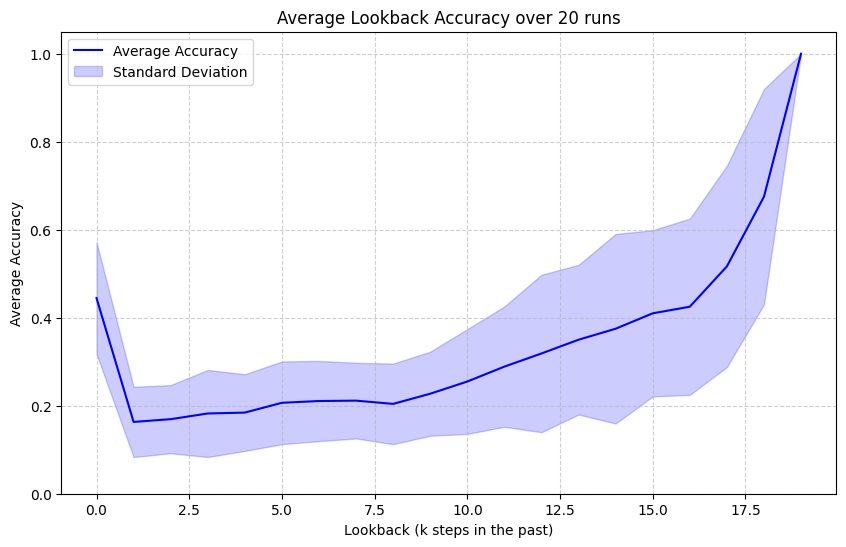

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.func import functional_call

import matplotlib.pyplot as plt
from tqdm import tqdm

from new_mem_module import metaRNN, lookback_accuracy_fn
from synthetic_datasets import InContextRecallDataset
from losses import windowed_p_loss

#torch.manual_seed(0) # You can uncomment this for reproducible runs

class LinearModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim, bias=False)

    def forward(self, x):
        return self.linear(x)

# --- Configuration ---
n_features = 10
seq_len = 20
num_runs = 20  # The number of times 'k' to run the simulation
loss_fn = windowed_p_loss
context_size = 1

online_module = metaRNN(
    loss_fn=loss_fn,
    memory_module=LinearModel(n_features, n_features),
    context_size=context_size)
# --- Main execution logic ---

# Store the lookback accuracy from each run

all_lookback_accuracies = []

print(f"Running simulation {num_runs} times...")

for i in tqdm(range(num_runs), desc="Running Simulations"):
    # 1. Re-initialize the model for each run to start from a fresh state.
    #    This is crucial for a fair average.
    lookback_correct_counts =[0]*seq_len 
    lookback_total_counts = [0]*seq_len
    memory_module = LinearModel(n_features, n_features)
    param_dict = {name: p for name, p in memory_module.named_parameters()}

    # 2. Generate a new random dataset for each run.
    my_dataset = InContextRecallDataset(seq_len, n_features,context_size, 0, 0)

    for j in range(len(my_dataset)):
        input, target = my_dataset[j]
        new_param_dict = online_module(param_dict, input, target)
        #evaluate lookback accuracy
        input_slice, target_slice = my_dataset[:j+1]
        preds = [functional_call(memory_module, new_param_dict, input) for input in input_slice]

        #evaluate function and modify lookback counts
        lookback_accuracy_fn(j, preds, target_slice, lookback_correct_counts, lookback_total_counts)

    # Calculate lookback accuracies for this run
    lookback_accuracies = []
    for k in range(len(lookback_correct_counts)):
        if lookback_total_counts[k] > 0:
            accuracy = lookback_correct_counts[k] / lookback_total_counts[k]
        else:
            accuracy = 0.0
        lookback_accuracies.append(accuracy)
    all_lookback_accuracies.append(lookback_accuracies)

    # --- Averaging and Plotting ---
#plt can handle pytorch. no need to convert to numpy

# Convert the list of lists into a 2D tensor for easy computation
accuracies_tensor = torch.tensor(all_lookback_accuracies)

# Calculate the mean and standard deviation across all runs
avg_lookback_acc = torch.mean(accuracies_tensor, dim=0)
std_dev_acc = torch.std(accuracies_tensor, dim=0)

# 'lookback' is a list of numbers from 0 to n-1
lookback = list(range(seq_len))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(lookback, avg_lookback_acc, label='Average Accuracy', color='blue')

# Add a shaded region for the standard deviation
plt.fill_between(
    lookback,
    (avg_lookback_acc - std_dev_acc).numpy(),
    (avg_lookback_acc + std_dev_acc).numpy(),
    color='blue',
    alpha=0.2,
    label='Standard Deviation'
)


# Add labels and a title for clarity
plt.xlabel("Lookback (k steps in the past)")
plt.ylabel("Average Accuracy")
plt.title(f"Average Lookback Accuracy over {num_runs} runs")
plt.legend()

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, 1.05) # Set y-axis limits from 0 to 1 for accuracy

# Show the plot
plt.show()
